In [4]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [5]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [6]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


In [7]:
from matplotlib import pyplot as plt
from torch_geometric.utils import  degree
# plt.hist(degree(dataset.edge_index[0]), bins=100);

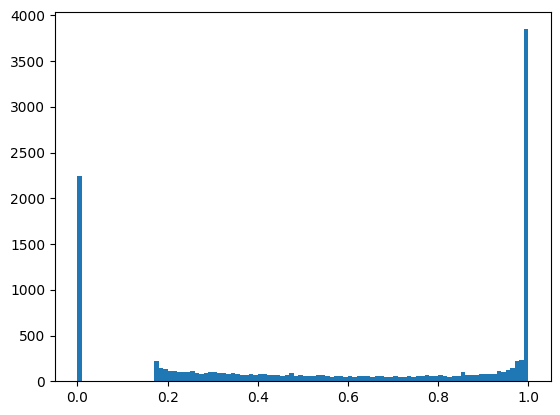

In [8]:
plt.hist(dataset.x[:, 0], bins=100);

In [9]:
dataset.num_features
# try implement this
# dataset.num_nodes

1

In [10]:
import copy
import os.path as osp
import time

import torch
import torch.nn.functional as F
from tqdm import tqdm

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device, 'x', 'y', 'train_mask', 'val_mask', 'test_mask')

In [28]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score
import numpy as np

kwargs = {'batch_size': 256, 'num_workers': 4, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[50], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        # self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                # x = F.dropout(x, p=0.5, training=self.training)
            # x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                # x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.binary_cross_entropy_with_logits(y_hat.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        # total_loss += float(loss) * batch.batch_size
        # total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples


@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_hat = torch.nn.functional.sigmoid(y_hat)
    y_pred = torch.where(y_hat > 0.5, 1, 0)
    y = torch.where(data.y > 0.95, 1, 0)
    y = y.to(y_hat.device)

    auroc = BinaryAUROC()

    accs = []
    aucs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_pred[mask] == y[mask]).sum()) / int(mask.sum()))
        aucs.append(auroc(y_hat[mask], y[mask]))
        
    
        
    # loss = []
    # for mask in [data.train_mask, data.val_mask, data.test_mask]:
    #     loss.append(F.binary_cross_entropy_with_logits(y_hat[mask], y[mask]))
    return accs, aucs

In [ ]:

times = []
for epoch in range(1, 101):
    start = time.time()
    loss, acc = train(epoch)
    # print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    accs, aucs = test()
    train_acc, val_acc, test_acc = accs
    train_auc, val_auc, test_auc = aucs
    print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    print(f'Epoch: {epoch:02d}, Train: {train_auc:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")



  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 01:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 01:   3%|▎         | 256/10144 [00:06<04:05, 40.35it/s]

Epoch 01:  23%|██▎       | 2304/10144 [00:06<00:15, 490.47it/s]

Epoch 01:  43%|████▎     | 4352/10144 [00:06<00:05, 1095.58it/s]

Epoch 01:  68%|██████▊   | 6912/10144 [00:06<00:01, 2113.83it/s]

Epoch 01: 100%|██████████| 10144/10144 [00:06<00:00, 1497.31it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   1%|          | 256/25360 [00:04<07:10, 58.36it/s]

Evaluating:   3%|▎         | 768/25360 [00:04<01:54, 214.06it/s]

Evaluating:   4%|▍         | 1024/25360 [00:04<01:18, 310.12it/s]

Evaluating:  23%|██▎       | 5888/25360 [00:04<00:06, 3037.25it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:04<00:02, 6240.52it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:04<00:01, 9656.38it/s]

Evaluating:  72%|███████▏  | 18312/25360 [00:05<00:00, 12763.34it/s]



Epoch: 01, Train: 0.6081, Val: 0.6183, Test: 0.5868
Epoch: 01, Train: 0.6668, Val: 0.6865, Test: 0.6408




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 02:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 02:  25%|██▌       | 2560/10144 [00:00<00:00, 23617.10it/s]

Epoch 02:  53%|█████▎    | 5376/10144 [00:00<00:00, 25527.25it/s]

Epoch 02: 100%|██████████| 10144/10144 [00:00<00:00, 26582.47it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35134.55it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 39540.93it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 40091.22it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 37204.51it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 37432.62it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38485.24it/s]


Epoch: 02, Train: 0.7566, Val: 0.7737, Test: 0.7421
Epoch: 02, Train: 0.8152, Val: 0.8372, Test: 0.8023




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 03:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 03:  23%|██▎       | 2304/10144 [00:00<00:00, 22039.99it/s]

Epoch 03:  50%|█████     | 5120/10144 [00:00<00:00, 25217.64it/s]

Epoch 03: 100%|██████████| 10144/10144 [00:00<00:00, 25953.94it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35199.04it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38376.12it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 39255.09it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 33117.40it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 31967.10it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 32791.20it/s]


Epoch: 03, Train: 0.7937, Val: 0.8091, Test: 0.7823
Epoch: 03, Train: 0.8549, Val: 0.8721, Test: 0.8454




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 04:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 04:  20%|██        | 2048/10144 [00:00<00:00, 19604.29it/s]

Epoch 04:  43%|████▎     | 4352/10144 [00:00<00:00, 20814.06it/s]

Epoch 04: 100%|██████████| 10144/10144 [00:00<00:00, 25255.57it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  10%|█         | 2560/25360 [00:00<00:00, 24293.96it/s]

Evaluating:  22%|██▏       | 5632/25360 [00:00<00:00, 26030.16it/s]

Evaluating:  34%|███▍      | 8704/25360 [00:00<00:00, 26693.12it/s]

Evaluating:  48%|████▊     | 12288/25360 [00:00<00:00, 29952.68it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 29246.12it/s]

Evaluating:  75%|███████▌  | 19080/25360 [00:00<00:00, 30737.31it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 30076.50it/s]


Epoch: 04, Train: 0.7980, Val: 0.8170, Test: 0.7950
Epoch: 04, Train: 0.8655, Val: 0.8824, Test: 0.8562




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 05:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 05:  23%|██▎       | 2304/10144 [00:00<00:00, 19704.90it/s]

Epoch 05:  50%|█████     | 5120/10144 [00:00<00:00, 24204.96it/s]

Epoch 05: 100%|██████████| 10144/10144 [00:00<00:00, 24285.13it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 33148.44it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 38807.45it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 39700.40it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 35913.08it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 35845.53it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36085.42it/s]


Epoch: 05, Train: 0.8055, Val: 0.8218, Test: 0.7942
Epoch: 05, Train: 0.8745, Val: 0.8887, Test: 0.8657




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 06:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 06:  20%|██        | 2048/10144 [00:00<00:00, 20323.32it/s]

Epoch 06:  45%|████▌     | 4608/10144 [00:00<00:00, 22750.16it/s]

Epoch 06: 100%|██████████| 10144/10144 [00:00<00:00, 26061.10it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 3840/25360 [00:00<00:00, 37289.09it/s]

Evaluating:  33%|███▎      | 8448/25360 [00:00<00:00, 41229.09it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 42333.99it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 37710.00it/s]

Evaluating:  84%|████████▍ | 21384/25360 [00:00<00:00, 38279.61it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38795.09it/s]


Epoch: 06, Train: 0.8078, Val: 0.8233, Test: 0.8005
Epoch: 06, Train: 0.8776, Val: 0.8910, Test: 0.8685




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 07:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 07:  23%|██▎       | 2304/10144 [00:00<00:00, 20063.02it/s]

Epoch 07:  53%|█████▎    | 5376/10144 [00:00<00:00, 23984.33it/s]

Epoch 07: 100%|██████████| 10144/10144 [00:00<00:00, 25385.00it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 28094.45it/s]

Evaluating:  25%|██▌       | 6400/25360 [00:00<00:00, 31699.17it/s]

Evaluating:  39%|███▉      | 9984/25360 [00:00<00:00, 33350.56it/s]

Evaluating:  53%|█████▎    | 13448/25360 [00:00<00:00, 31033.64it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 30393.77it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 30914.65it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 31242.67it/s]


Epoch: 07, Train: 0.8099, Val: 0.8218, Test: 0.7902
Epoch: 07, Train: 0.8822, Val: 0.8940, Test: 0.8726




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 08:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 08:  13%|█▎        | 1280/10144 [00:00<00:00, 11444.60it/s]

Epoch 08:  35%|███▌      | 3584/10144 [00:00<00:00, 17349.22it/s]

Epoch 08:  63%|██████▎   | 6400/10144 [00:00<00:00, 21460.52it/s]

Epoch 08: 100%|██████████| 10144/10144 [00:00<00:00, 22751.03it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32206.19it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37868.32it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 42449.31it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 38446.04it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39345.23it/s]


Epoch: 08, Train: 0.8110, Val: 0.8233, Test: 0.7871
Epoch: 08, Train: 0.8852, Val: 0.8971, Test: 0.8756




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 09:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 09:  23%|██▎       | 2304/10144 [00:00<00:00, 22457.48it/s]

Epoch 09:  56%|█████▌    | 5632/10144 [00:00<00:00, 28383.07it/s]

Epoch 09: 100%|██████████| 10144/10144 [00:00<00:00, 25793.92it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31665.11it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36119.17it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 38444.13it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 35968.42it/s]

Evaluating:  78%|███████▊  | 19848/25360 [00:00<00:00, 37511.32it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37961.63it/s]


Epoch: 09, Train: 0.8121, Val: 0.8226, Test: 0.7918
Epoch: 09, Train: 0.8862, Val: 0.8977, Test: 0.8766




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 10:  23%|██▎       | 2304/10144 [00:00<00:00, 21276.21it/s]

Epoch 10:  48%|████▊     | 4864/10144 [00:00<00:00, 23295.71it/s]

Epoch 10: 100%|██████████| 10144/10144 [00:00<00:00, 25942.48it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34467.20it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37454.02it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 37567.26it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 36223.12it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 36263.92it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37226.74it/s]


Epoch: 10, Train: 0.8124, Val: 0.8226, Test: 0.7918
Epoch: 10, Train: 0.8871, Val: 0.8984, Test: 0.8775




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 11:  18%|█▊        | 1792/10144 [00:00<00:00, 17361.14it/s]

Epoch 11:  43%|████▎     | 4352/10144 [00:00<00:00, 18673.48it/s]

Epoch 11:  63%|██████▎   | 6400/10144 [00:00<00:00, 19336.48it/s]

Epoch 11: 100%|██████████| 10144/10144 [00:00<00:00, 22850.34it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34314.40it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 37169.98it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 38719.27it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 36738.50it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 38827.03it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38951.16it/s]


Epoch: 11, Train: 0.8130, Val: 0.8241, Test: 0.7926
Epoch: 11, Train: 0.8885, Val: 0.8995, Test: 0.8789




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 12:  20%|██        | 2048/10144 [00:00<00:00, 19901.43it/s]

Epoch 12:  45%|████▌     | 4608/10144 [00:00<00:00, 23190.30it/s]

Epoch 12: 100%|██████████| 10144/10144 [00:00<00:00, 26504.04it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35491.91it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36353.96it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 38076.24it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 35925.00it/s]

Evaluating:  78%|███████▊  | 19848/25360 [00:00<00:00, 38354.74it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37521.30it/s]


Epoch: 12, Train: 0.8137, Val: 0.8241, Test: 0.7934
Epoch: 12, Train: 0.8894, Val: 0.8999, Test: 0.8797




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 13:  15%|█▌        | 1536/10144 [00:00<00:00, 14793.81it/s]

Epoch 13:  43%|████▎     | 4352/10144 [00:00<00:00, 21208.25it/s]

Epoch 13: 100%|██████████| 10144/10144 [00:00<00:00, 24545.14it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 33044.08it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 37503.85it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 40724.46it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 36357.30it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 35319.50it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34270.37it/s]


Epoch: 13, Train: 0.8088, Val: 0.8218, Test: 0.7831
Epoch: 13, Train: 0.8905, Val: 0.9009, Test: 0.8807




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 14:  23%|██▎       | 2304/10144 [00:00<00:00, 21598.67it/s]

Epoch 14:  53%|█████▎    | 5376/10144 [00:00<00:00, 26404.34it/s]

Epoch 14: 100%|██████████| 10144/10144 [00:00<00:00, 28715.86it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  16%|█▌        | 4096/25360 [00:00<00:00, 40019.45it/s]

Evaluating:  32%|███▏      | 8192/25360 [00:00<00:00, 40169.77it/s]

Evaluating:  48%|████▊     | 12288/25360 [00:00<00:00, 39343.99it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 34573.55it/s]

Evaluating:  78%|███████▊  | 19848/25360 [00:00<00:00, 32730.61it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 28795.05it/s]


Epoch: 14, Train: 0.8094, Val: 0.8226, Test: 0.7839
Epoch: 14, Train: 0.8910, Val: 0.9012, Test: 0.8811




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 15:  18%|█▊        | 1792/10144 [00:00<00:00, 16957.96it/s]

Epoch 15:  43%|████▎     | 4352/10144 [00:00<00:00, 21225.98it/s]

Epoch 15:  68%|██████▊   | 6912/10144 [00:00<00:00, 23162.85it/s]

Epoch 15: 100%|██████████| 10144/10144 [00:00<00:00, 23681.14it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27312.51it/s]

Evaluating:  23%|██▎       | 5888/25360 [00:00<00:00, 28518.90it/s]

Evaluating:  36%|███▋      | 9216/25360 [00:00<00:00, 29614.50it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 30999.30it/s]

Evaluating:  65%|██████▌   | 16520/25360 [00:00<00:00, 31258.98it/s]

Evaluating:  80%|████████  | 20360/25360 [00:00<00:00, 32775.17it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33049.88it/s]


Epoch: 15, Train: 0.8072, Val: 0.8194, Test: 0.7879
Epoch: 15, Train: 0.8915, Val: 0.9012, Test: 0.8822




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 16:  23%|██▎       | 2304/10144 [00:00<00:00, 19879.40it/s]

Epoch 16:  53%|█████▎    | 5376/10144 [00:00<00:00, 25206.45it/s]

Epoch 16: 100%|██████████| 10144/10144 [00:00<00:00, 25419.16it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   4%|▍         | 1024/25360 [00:00<00:02, 9771.73it/s]

Evaluating:  18%|█▊        | 4608/25360 [00:00<00:00, 23621.22it/s]

Evaluating:  34%|███▍      | 8704/25360 [00:00<00:00, 30613.07it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 30325.83it/s]

Evaluating:  59%|█████▉    | 14984/25360 [00:00<00:00, 29029.19it/s]

Evaluating:  72%|███████▏  | 18312/25360 [00:00<00:00, 30228.99it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 30827.81it/s]


Epoch: 16, Train: 0.8104, Val: 0.8218, Test: 0.7847
Epoch: 16, Train: 0.8914, Val: 0.9017, Test: 0.8819




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 17:  20%|██        | 2048/10144 [00:00<00:00, 19633.60it/s]

Epoch 17:  40%|████      | 4096/10144 [00:00<00:00, 17759.60it/s]

Epoch 17:  61%|██████    | 6144/10144 [00:00<00:00, 17961.73it/s]

Epoch 17: 100%|██████████| 10144/10144 [00:00<00:00, 19691.89it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 33018.18it/s]

Evaluating:  33%|███▎      | 8448/25360 [00:00<00:00, 40197.06it/s]

Evaluating:  50%|█████     | 12680/25360 [00:00<00:00, 40719.54it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 36352.38it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 34712.09it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35979.29it/s]


Epoch: 17, Train: 0.8083, Val: 0.8226, Test: 0.7847
Epoch: 17, Train: 0.8918, Val: 0.9019, Test: 0.8829




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 18:  20%|██        | 2048/10144 [00:00<00:00, 19356.20it/s]

Epoch 18:  43%|████▎     | 4352/10144 [00:00<00:00, 20732.87it/s]

Epoch 18: 100%|██████████| 10144/10144 [00:00<00:00, 24507.99it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32209.01it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36298.81it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 38644.97it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 36220.53it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 33088.94it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35604.98it/s]


Epoch: 18, Train: 0.8115, Val: 0.8226, Test: 0.7886
Epoch: 18, Train: 0.8919, Val: 0.9021, Test: 0.8829




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 19:  23%|██▎       | 2304/10144 [00:00<00:00, 22903.51it/s]

Epoch 19:  53%|█████▎    | 5376/10144 [00:00<00:00, 24947.09it/s]

Epoch 19: 100%|██████████| 10144/10144 [00:00<00:00, 24943.01it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 28149.29it/s]

Evaluating:  24%|██▍       | 6144/25360 [00:00<00:00, 30575.58it/s]

Evaluating:  37%|███▋      | 9472/25360 [00:00<00:00, 31243.44it/s]

Evaluating:  52%|█████▏    | 13192/25360 [00:00<00:00, 32927.19it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 34558.17it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35467.64it/s]


Epoch: 19, Train: 0.8061, Val: 0.8162, Test: 0.7855
Epoch: 19, Train: 0.8922, Val: 0.9017, Test: 0.8832




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 20:  23%|██▎       | 2304/10144 [00:00<00:00, 20468.56it/s]

Epoch 20:  50%|█████     | 5120/10144 [00:00<00:00, 24640.99it/s]

Epoch 20:  76%|███████▌  | 7680/10144 [00:00<00:00, 23093.37it/s]

Epoch 20: 100%|██████████| 10144/10144 [00:00<00:00, 22491.65it/s]


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   8%|▊         | 2048/25360 [00:00<00:01, 19920.63it/s]

Evaluating:  17%|█▋        | 4352/25360 [00:00<00:01, 20626.53it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 22199.81it/s]

Evaluating:  37%|███▋      | 9472/25360 [00:00<00:00, 23466.09it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 25699.38it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 24208.32it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 26170.91it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<

Epoch: 20, Train: 0.8047, Val: 0.8091, Test: 0.7863
Epoch: 20, Train: 0.8924, Val: 0.9015, Test: 0.8833




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 21:  20%|██        | 2048/10144 [00:00<00:00, 20458.12it/s]

Epoch 21:  45%|████▌     | 4608/10144 [00:00<00:00, 22713.62it/s]

Epoch 21:  68%|██████▊   | 6912/10144 [00:00<00:00, 22085.73it/s]

Epoch 21: 100%|██████████| 10144/10144 [00:00<00:00, 22512.47it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  10%|█         | 2560/25360 [00:00<00:00, 23361.72it/s]

Evaluating:  22%|██▏       | 5632/25360 [00:00<00:00, 26888.58it/s]

Evaluating:  34%|███▍      | 8704/25360 [00:00<00:00, 28440.07it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 33076.66it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 34432.70it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 35530.86it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33595.27it/s]


Epoch: 21, Train: 0.8065, Val: 0.8115, Test: 0.7871
Epoch: 21, Train: 0.8926, Val: 0.9017, Test: 0.8836




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 22:  18%|█▊        | 1792/10144 [00:00<00:00, 17750.06it/s]

Epoch 22:  45%|████▌     | 4608/10144 [00:00<00:00, 23828.45it/s]

Epoch 22: 100%|██████████| 10144/10144 [00:00<00:00, 25478.84it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 28645.69it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 35353.94it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 41251.98it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 39241.26it/s]

Evaluating:  82%|████████▏ | 20872/25360 [00:00<00:00, 38932.23it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37526.33it/s]


Epoch: 22, Train: 0.8057, Val: 0.8099, Test: 0.7879
Epoch: 22, Train: 0.8927, Val: 0.9017, Test: 0.8838




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 23:  20%|██        | 2048/10144 [00:00<00:00, 20357.66it/s]

Epoch 23:  48%|████▊     | 4864/10144 [00:00<00:00, 24815.25it/s]

Epoch 23: 100%|██████████| 10144/10144 [00:00<00:00, 25422.86it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32202.40it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 39448.60it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 40206.39it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 36017.36it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38310.17it/s]


Epoch: 23, Train: 0.8113, Val: 0.8226, Test: 0.7871
Epoch: 23, Train: 0.8928, Val: 0.9022, Test: 0.8842




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 24:  23%|██▎       | 2304/10144 [00:00<00:00, 20661.46it/s]

Epoch 24:  53%|█████▎    | 5376/10144 [00:00<00:00, 25955.27it/s]

Epoch 24: 100%|██████████| 10144/10144 [00:00<00:00, 27039.56it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31307.38it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 35211.09it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 39980.20it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 36062.28it/s]

Evaluating:  78%|███████▊  | 19848/25360 [00:00<00:00, 36120.49it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36821.88it/s]


Epoch: 24, Train: 0.8080, Val: 0.8170, Test: 0.7831
Epoch: 24, Train: 0.8930, Val: 0.9020, Test: 0.8841




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 25:  23%|██▎       | 2304/10144 [00:00<00:00, 20090.34it/s]

Epoch 25:  53%|█████▎    | 5376/10144 [00:00<00:00, 24232.59it/s]

Epoch 25: 100%|██████████| 10144/10144 [00:00<00:00, 26263.27it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31593.22it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 39581.76it/s]

Evaluating:  48%|████▊     | 12288/25360 [00:00<00:00, 40777.43it/s]

Evaluating:  65%|██████▌   | 16520/25360 [00:00<00:00, 38088.66it/s]

Evaluating:  82%|████████▏ | 20872/25360 [00:00<00:00, 39479.62it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39053.41it/s]


Epoch: 25, Train: 0.7938, Val: 0.7973, Test: 0.7705
Epoch: 25, Train: 0.8930, Val: 0.9012, Test: 0.8842




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 26:  23%|██▎       | 2304/10144 [00:00<00:00, 21436.92it/s]

Epoch 26:  50%|█████     | 5120/10144 [00:00<00:00, 24923.79it/s]

Epoch 26: 100%|██████████| 10144/10144 [00:00<00:00, 26284.56it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32697.69it/s]

Evaluating:  32%|███▏      | 8192/25360 [00:00<00:00, 41777.47it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 38719.23it/s]

Evaluating:  65%|██████▌   | 16520/25360 [00:00<00:00, 35841.91it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39557.88it/s]


Epoch: 26, Train: 0.8034, Val: 0.8076, Test: 0.7784
Epoch: 26, Train: 0.8932, Val: 0.9016, Test: 0.8845




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 27:  23%|██▎       | 2304/10144 [00:00<00:00, 22234.46it/s]

Epoch 27:  48%|████▊     | 4864/10144 [00:00<00:00, 22024.97it/s]

Epoch 27:  71%|███████   | 7168/10144 [00:00<00:00, 22024.55it/s]

Epoch 27: 100%|██████████| 10144/10144 [00:00<00:00, 23046.01it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31746.34it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 32634.89it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 38981.13it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 36234.81it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 36228.32it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36309.39it/s]


Epoch: 27, Train: 0.8033, Val: 0.8068, Test: 0.7800
Epoch: 27, Train: 0.8933, Val: 0.9016, Test: 0.8847




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 28:  23%|██▎       | 2304/10144 [00:00<00:00, 19655.68it/s]

Epoch 28:  53%|█████▎    | 5376/10144 [00:00<00:00, 25007.55it/s]

Epoch 28: 100%|██████████| 10144/10144 [00:00<00:00, 26800.39it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31140.59it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 33117.69it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 34184.68it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 35142.08it/s]

Evaluating:  70%|███████   | 17800/25360 [00:00<00:00, 33916.18it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34904.43it/s]


Epoch: 28, Train: 0.8064, Val: 0.8084, Test: 0.7847
Epoch: 28, Train: 0.8934, Val: 0.9018, Test: 0.8848




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 29:  20%|██        | 2048/10144 [00:00<00:00, 19557.69it/s]

Epoch 29:  48%|████▊     | 4864/10144 [00:00<00:00, 24298.13it/s]

Epoch 29:  73%|███████▎  | 7424/10144 [00:00<00:00, 24733.87it/s]

Epoch 29: 100%|██████████| 10144/10144 [00:00<00:00, 24673.71it/s]


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31362.81it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 34863.55it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 36261.71it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 33457.42it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 35664.22it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35551.51it/s]


Epoch: 29, Train: 0.8088, Val: 0.8162, Test: 0.7886
Epoch: 29, Train: 0.8936, Val: 0.9021, Test: 0.8849




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 30:  13%|█▎        | 1280/10144 [00:00<00:00, 12583.70it/s]

Epoch 30:  35%|███▌      | 3584/10144 [00:00<00:00, 18558.33it/s]

Epoch 30:  56%|█████▌    | 5632/10144 [00:00<00:00, 19223.75it/s]

Epoch 30: 100%|██████████| 10144/10144 [00:00<00:00, 22651.56it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27448.22it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 33239.57it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 38367.78it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 39143.98it/s]

Evaluating:  78%|███████▊  | 19848/25360 [00:00<00:00, 39396.35it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38622.61it/s]


Epoch: 30, Train: 0.8020, Val: 0.8076, Test: 0.7784
Epoch: 30, Train: 0.8936, Val: 0.9016, Test: 0.8850




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 31:  18%|█▊        | 1792/10144 [00:00<00:00, 17130.34it/s]

Epoch 31:  43%|████▎     | 4352/10144 [00:00<00:00, 19950.65it/s]

Epoch 31: 100%|██████████| 10144/10144 [00:00<00:00, 24001.12it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32039.41it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 35686.28it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 37947.37it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 36254.02it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 38611.14it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37283.16it/s]


Epoch: 31, Train: 0.8084, Val: 0.8107, Test: 0.7871
Epoch: 31, Train: 0.8938, Val: 0.9019, Test: 0.8852




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 32:  20%|██        | 2048/10144 [00:00<00:00, 19577.48it/s]

Epoch 32:  50%|█████     | 5120/10144 [00:00<00:00, 25535.70it/s]

Epoch 32: 100%|██████████| 10144/10144 [00:00<00:00, 26761.07it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31949.00it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 30620.83it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 33134.71it/s]

Evaluating:  55%|█████▌    | 13960/25360 [00:00<00:00, 32334.54it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 32642.87it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34417.23it/s]


Epoch: 32, Train: 0.7921, Val: 0.7981, Test: 0.7729
Epoch: 32, Train: 0.8937, Val: 0.9013, Test: 0.8852




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 33:  23%|██▎       | 2304/10144 [00:00<00:00, 19408.29it/s]

Epoch 33:  53%|█████▎    | 5376/10144 [00:00<00:00, 25128.67it/s]

Epoch 33: 100%|██████████| 10144/10144 [00:00<00:00, 26760.71it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 30239.15it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 35804.80it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 40950.88it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 37211.26it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 37069.97it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38177.29it/s]


Epoch: 33, Train: 0.8053, Val: 0.8076, Test: 0.7847
Epoch: 33, Train: 0.8940, Val: 0.9017, Test: 0.8855




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 34:  25%|██▌       | 2560/10144 [00:00<00:00, 22927.18it/s]

Epoch 34:  56%|█████▌    | 5632/10144 [00:00<00:00, 25945.99it/s]

Epoch 34: 100%|██████████| 10144/10144 [00:00<00:00, 26616.92it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 30199.32it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36940.66it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 39696.80it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 33612.63it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 34411.42it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36212.49it/s]


Epoch: 34, Train: 0.7952, Val: 0.7997, Test: 0.7737
Epoch: 34, Train: 0.8939, Val: 0.9012, Test: 0.8855




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 35:  23%|██▎       | 2304/10144 [00:00<00:00, 21281.93it/s]

Epoch 35:  50%|█████     | 5120/10144 [00:00<00:00, 24482.50it/s]

Epoch 35: 100%|██████████| 10144/10144 [00:00<00:00, 25781.21it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32320.05it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36275.13it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 35195.30it/s]

Evaluating:  59%|█████▉    | 14984/25360 [00:00<00:00, 33753.20it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 23256.29it/s]

Evaluating:  86%|████████▋ | 21896/25360 [00:00<00:00, 25656.24it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 27858.57it/s]


Epoch: 35, Train: 0.7965, Val: 0.8013, Test: 0.7800
Epoch: 35, Train: 0.8940, Val: 0.9012, Test: 0.8857




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 36:  20%|██        | 2048/10144 [00:00<00:00, 19490.46it/s]

Epoch 36:  48%|████▊     | 4864/10144 [00:00<00:00, 23234.33it/s]

Epoch 36: 100%|██████████| 10144/10144 [00:00<00:00, 24879.81it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34502.64it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37636.02it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 35425.28it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 32548.26it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 31641.92it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33420.71it/s]


Epoch: 36, Train: 0.7955, Val: 0.7989, Test: 0.7729
Epoch: 36, Train: 0.8941, Val: 0.9011, Test: 0.8857




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 37:  20%|██        | 2048/10144 [00:00<00:00, 17823.59it/s]

Epoch 37:  43%|████▎     | 4352/10144 [00:00<00:00, 20008.38it/s]

Epoch 37: 100%|██████████| 10144/10144 [00:00<00:00, 24210.25it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31015.56it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38263.81it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 41061.76it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 35071.64it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 34967.64it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36024.47it/s]


Epoch: 37, Train: 0.7883, Val: 0.7981, Test: 0.7666
Epoch: 37, Train: 0.8940, Val: 0.9010, Test: 0.8857




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 38:  18%|█▊        | 1792/10144 [00:00<00:00, 16819.00it/s]

Epoch 38:  48%|████▊     | 4864/10144 [00:00<00:00, 23924.67it/s]

Epoch 38: 100%|██████████| 10144/10144 [00:00<00:00, 25246.14it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27910.82it/s]

Evaluating:  25%|██▌       | 6400/25360 [00:00<00:00, 32279.86it/s]

Evaluating:  43%|████▎     | 11008/25360 [00:00<00:00, 38087.47it/s]

Evaluating:  59%|█████▉    | 14984/25360 [00:00<00:00, 37160.84it/s]

Evaluating:  75%|███████▌  | 19080/25360 [00:00<00:00, 38200.38it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36202.47it/s]


Epoch: 38, Train: 0.7945, Val: 0.7989, Test: 0.7760
Epoch: 38, Train: 0.8941, Val: 0.9011, Test: 0.8859




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 39:  23%|██▎       | 2304/10144 [00:00<00:00, 19921.00it/s]

Epoch 39:  53%|█████▎    | 5376/10144 [00:00<00:00, 24299.92it/s]

Epoch 39: 100%|██████████| 10144/10144 [00:00<00:00, 27174.87it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  10%|█         | 2560/25360 [00:00<00:00, 23915.46it/s]

Evaluating:  22%|██▏       | 5632/25360 [00:00<00:00, 27504.68it/s]

Evaluating:  37%|███▋      | 9472/25360 [00:00<00:00, 31884.57it/s]

Evaluating:  53%|█████▎    | 13448/25360 [00:00<00:00, 34358.44it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 33451.56it/s]

Evaluating:  83%|████████▎ | 21128/25360 [00:00<00:00, 35315.42it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34199.11it/s]


Epoch: 39, Train: 0.7946, Val: 0.7989, Test: 0.7776
Epoch: 39, Train: 0.8941, Val: 0.9011, Test: 0.8859




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 40:  15%|█▌        | 1536/10144 [00:00<00:00, 15071.51it/s]

Epoch 40:  40%|████      | 4096/10144 [00:00<00:00, 21003.64it/s]

Epoch 40:  68%|██████▊   | 6912/10144 [00:00<00:00, 23998.26it/s]

Epoch 40: 100%|██████████| 10144/10144 [00:00<00:00, 24324.68it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32045.96it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 35871.41it/s]

Evaluating:  43%|████▎     | 11008/25360 [00:00<00:00, 33650.52it/s]

Evaluating:  57%|█████▋    | 14472/25360 [00:00<00:00, 32247.56it/s]

Evaluating:  71%|███████   | 18056/25360 [00:00<00:00, 32720.05it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35869.78it/s]


Epoch: 40, Train: 0.7982, Val: 0.8052, Test: 0.7847
Epoch: 40, Train: 0.8942, Val: 0.9014, Test: 0.8861




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 41:  18%|█▊        | 1792/10144 [00:00<00:00, 17144.37it/s]

Epoch 41:  43%|████▎     | 4352/10144 [00:00<00:00, 20573.44it/s]

Epoch 41: 100%|██████████| 10144/10144 [00:00<00:00, 24667.70it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 32747.66it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 31902.36it/s]

Evaluating:  42%|████▏     | 10752/25360 [00:00<00:00, 30225.28it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 31514.18it/s]

Evaluating:  69%|██████▉   | 17544/25360 [00:00<00:00, 31224.59it/s]

Evaluating:  82%|████████▏ | 20872/25360 [00:00<00:00, 30582.75it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 30753.19it/s]


Epoch: 41, Train: 0.8010, Val: 0.8099, Test: 0.7855
Epoch: 41, Train: 0.8943, Val: 0.9014, Test: 0.8861




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 42:  13%|█▎        | 1280/10144 [00:00<00:00, 12282.54it/s]

Epoch 42:  40%|████      | 4096/10144 [00:00<00:00, 21407.76it/s]

Epoch 42:  68%|██████▊   | 6912/10144 [00:00<00:00, 24210.26it/s]

Epoch 42: 100%|██████████| 10144/10144 [00:00<00:00, 24242.56it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34243.90it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 32974.90it/s]

Evaluating:  42%|████▏     | 10752/25360 [00:00<00:00, 33030.07it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 29271.64it/s]

Evaluating:  70%|███████   | 17800/25360 [00:00<00:00, 31316.42it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33182.99it/s]


Epoch: 42, Train: 0.8070, Val: 0.8084, Test: 0.7839
Epoch: 42, Train: 0.8944, Val: 0.9016, Test: 0.8862




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 43:  18%|█▊        | 1792/10144 [00:00<00:00, 17759.08it/s]

Epoch 43:  43%|████▎     | 4352/10144 [00:00<00:00, 21923.68it/s]

Epoch 43:  66%|██████▌   | 6656/10144 [00:00<00:00, 22318.83it/s]

Epoch 43: 100%|██████████| 10144/10144 [00:00<00:00, 23992.59it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31270.34it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 35336.70it/s]

Evaluating:  43%|████▎     | 11008/25360 [00:00<00:00, 36363.56it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:00<00:00, 36378.75it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 36578.60it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36628.56it/s]


Epoch: 43, Train: 0.8014, Val: 0.8107, Test: 0.7855
Epoch: 43, Train: 0.8943, Val: 0.9015, Test: 0.8863




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 44:  13%|█▎        | 1280/10144 [00:00<00:00, 12528.37it/s]

Epoch 44:  43%|████▎     | 4352/10144 [00:00<00:00, 22748.43it/s]

Epoch 44: 100%|██████████| 10144/10144 [00:00<00:00, 26967.32it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31348.23it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 33868.89it/s]

Evaluating:  42%|████▏     | 10752/25360 [00:00<00:00, 35276.12it/s]

Evaluating:  57%|█████▋    | 14472/25360 [00:00<00:00, 35944.31it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 37251.47it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36087.56it/s]


Epoch: 44, Train: 0.7920, Val: 0.8005, Test: 0.7737
Epoch: 44, Train: 0.8943, Val: 0.9011, Test: 0.8863




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 45:  20%|██        | 2048/10144 [00:00<00:00, 19976.96it/s]

Epoch 45:  48%|████▊     | 4864/10144 [00:00<00:00, 24468.87it/s]

Epoch 45: 100%|██████████| 10144/10144 [00:00<00:00, 26530.39it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 29839.15it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 32531.67it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 34297.00it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 35062.31it/s]

Evaluating:  70%|███████   | 17800/25360 [00:00<00:00, 34211.46it/s]

Evaluating:  84%|████████▍ | 21384/25360 [00:00<00:00, 33988.34it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34522.86it/s]


Epoch: 45, Train: 0.8021, Val: 0.8115, Test: 0.7855
Epoch: 45, Train: 0.8944, Val: 0.9015, Test: 0.8864




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 46:  20%|██        | 2048/10144 [00:00<00:00, 20195.31it/s]

Epoch 46:  45%|████▌     | 4608/10144 [00:00<00:00, 23297.18it/s]

Epoch 46: 100%|██████████| 10144/10144 [00:00<00:00, 25448.20it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32462.57it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 37398.88it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 37410.72it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 33690.97it/s]

Evaluating:  74%|███████▍  | 18824/25360 [00:00<00:00, 34043.05it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34814.36it/s]


Epoch: 46, Train: 0.8011, Val: 0.8076, Test: 0.7847
Epoch: 46, Train: 0.8945, Val: 0.9014, Test: 0.8864




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 47:  18%|█▊        | 1792/10144 [00:00<00:00, 17680.96it/s]

Epoch 47:  43%|████▎     | 4352/10144 [00:00<00:00, 21248.41it/s]

Epoch 47: 100%|██████████| 10144/10144 [00:00<00:00, 25361.78it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35576.33it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38010.45it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 36654.68it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 34800.36it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 36312.15it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36533.40it/s]


Epoch: 47, Train: 0.7951, Val: 0.8021, Test: 0.7768
Epoch: 47, Train: 0.8944, Val: 0.9011, Test: 0.8865




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 48:  20%|██        | 2048/10144 [00:00<00:00, 20280.28it/s]

Epoch 48:  48%|████▊     | 4864/10144 [00:00<00:00, 24058.59it/s]

Epoch 48: 100%|██████████| 10144/10144 [00:00<00:00, 26893.06it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35461.60it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36549.74it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 42278.15it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 37876.10it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 37880.86it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38852.86it/s]


Epoch: 48, Train: 0.7960, Val: 0.8005, Test: 0.7792
Epoch: 48, Train: 0.8945, Val: 0.9013, Test: 0.8866




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 49:  20%|██        | 2048/10144 [00:00<00:00, 20347.53it/s]

Epoch 49:  48%|████▊     | 4864/10144 [00:00<00:00, 24911.70it/s]

Epoch 49: 100%|██████████| 10144/10144 [00:00<00:00, 26589.93it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 30388.78it/s]

Evaluating:  25%|██▌       | 6400/25360 [00:00<00:00, 31057.40it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 35124.21it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:00<00:00, 37784.94it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 37635.28it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35001.99it/s]


Epoch: 49, Train: 0.7981, Val: 0.8044, Test: 0.7863
Epoch: 49, Train: 0.8946, Val: 0.9014, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 50:  23%|██▎       | 2304/10144 [00:00<00:00, 20035.49it/s]

Epoch 50:  53%|█████▎    | 5376/10144 [00:00<00:00, 23424.79it/s]

Epoch 50: 100%|██████████| 10144/10144 [00:00<00:00, 26106.58it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35629.11it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 39153.69it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 41723.93it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 39176.51it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 40986.91it/s]


Epoch: 50, Train: 0.7886, Val: 0.8028, Test: 0.7729
Epoch: 50, Train: 0.8945, Val: 0.9012, Test: 0.8866




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 51:  23%|██▎       | 2304/10144 [00:00<00:00, 20600.33it/s]

Epoch 51:  53%|█████▎    | 5376/10144 [00:00<00:00, 25532.03it/s]

Epoch 51: 100%|██████████| 10144/10144 [00:00<00:00, 27642.06it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34374.98it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38678.93it/s]

Evaluating:  50%|█████     | 12680/25360 [00:00<00:00, 42086.33it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 39683.67it/s]

Evaluating:  83%|████████▎ | 21128/25360 [00:00<00:00, 38895.88it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38834.89it/s]


Epoch: 51, Train: 0.7933, Val: 0.7997, Test: 0.7737
Epoch: 51, Train: 0.8946, Val: 0.9012, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 52:  23%|██▎       | 2304/10144 [00:00<00:00, 21702.42it/s]

Epoch 52:  56%|█████▌    | 5632/10144 [00:00<00:00, 27327.99it/s]

Epoch 52: 100%|██████████| 10144/10144 [00:00<00:00, 26637.45it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 33103.24it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 40145.81it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 43152.07it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 39716.94it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 41012.97it/s]


Epoch: 52, Train: 0.8040, Val: 0.8123, Test: 0.7863
Epoch: 52, Train: 0.8948, Val: 0.9016, Test: 0.8866




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 53:  23%|██▎       | 2304/10144 [00:00<00:00, 20779.60it/s]

Epoch 53:  53%|█████▎    | 5376/10144 [00:00<00:00, 25614.06it/s]

Epoch 53: 100%|██████████| 10144/10144 [00:00<00:00, 27316.04it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 3840/25360 [00:00<00:00, 35153.55it/s]

Evaluating:  33%|███▎      | 8448/25360 [00:00<00:00, 40343.11it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 38951.33it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 36226.11it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39137.92it/s]


Epoch: 53, Train: 0.7993, Val: 0.8076, Test: 0.7831
Epoch: 53, Train: 0.8947, Val: 0.9016, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 54:  25%|██▌       | 2560/10144 [00:00<00:00, 24014.78it/s]

Epoch 54:  56%|█████▌    | 5632/10144 [00:00<00:00, 27532.89it/s]

Epoch 54: 100%|██████████| 10144/10144 [00:00<00:00, 26825.33it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32758.54it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 37190.26it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 39301.98it/s]

Evaluating:  62%|██████▏   | 15752/25360 [00:00<00:00, 34323.23it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 34804.41it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36050.53it/s]


Epoch: 54, Train: 0.7923, Val: 0.8005, Test: 0.7744
Epoch: 54, Train: 0.8947, Val: 0.9013, Test: 0.8866




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 55:  23%|██▎       | 2304/10144 [00:00<00:00, 20115.06it/s]

Epoch 55:  53%|█████▎    | 5376/10144 [00:00<00:00, 24479.71it/s]

Epoch 55: 100%|██████████| 10144/10144 [00:00<00:00, 26660.00it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27726.70it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 33736.79it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 35398.01it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 33773.70it/s]

Evaluating:  71%|███████   | 18056/25360 [00:00<00:00, 33904.74it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35577.61it/s]


Epoch: 55, Train: 0.8048, Val: 0.8091, Test: 0.7855
Epoch: 55, Train: 0.8948, Val: 0.9018, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 56:  15%|█▌        | 1536/10144 [00:00<00:00, 15159.03it/s]

Epoch 56:  43%|████▎     | 4352/10144 [00:00<00:00, 22242.53it/s]

Epoch 56: 100%|██████████| 10144/10144 [00:00<00:00, 26867.90it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35680.78it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36614.76it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 38331.36it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 37395.51it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 37720.14it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39503.51it/s]


Epoch: 56, Train: 0.8021, Val: 0.8107, Test: 0.7871
Epoch: 56, Train: 0.8948, Val: 0.9016, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 57:  20%|██        | 2048/10144 [00:00<00:00, 19548.35it/s]

Epoch 57:  43%|████▎     | 4352/10144 [00:00<00:00, 21235.60it/s]

Epoch 57: 100%|██████████| 10144/10144 [00:00<00:00, 25218.14it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 3840/25360 [00:00<00:00, 34592.05it/s]

Evaluating:  34%|███▍      | 8704/25360 [00:00<00:00, 41334.66it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 39387.29it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 37448.76it/s]

Evaluating:  83%|████████▎ | 21128/25360 [00:00<00:00, 37651.45it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37804.59it/s]


Epoch: 57, Train: 0.7980, Val: 0.8052, Test: 0.7855
Epoch: 57, Train: 0.8949, Val: 0.9014, Test: 0.8868




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 58:  23%|██▎       | 2304/10144 [00:00<00:00, 21625.30it/s]

Epoch 58:  53%|█████▎    | 5376/10144 [00:00<00:00, 26275.21it/s]

Epoch 58: 100%|██████████| 10144/10144 [00:00<00:00, 27242.09it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34693.99it/s]

Evaluating:  33%|███▎      | 8448/25360 [00:00<00:00, 41878.26it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 42418.38it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 40392.37it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 39679.61it/s]


Epoch: 58, Train: 0.7939, Val: 0.8013, Test: 0.7768
Epoch: 58, Train: 0.8949, Val: 0.9013, Test: 0.8869




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 59:  23%|██▎       | 2304/10144 [00:00<00:00, 21447.96it/s]

Epoch 59:  53%|█████▎    | 5376/10144 [00:00<00:00, 26205.91it/s]

Epoch 59: 100%|██████████| 10144/10144 [00:00<00:00, 28274.80it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32694.47it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 31855.39it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 34690.51it/s]

Evaluating:  57%|█████▋    | 14472/25360 [00:00<00:00, 35954.73it/s]

Evaluating:  72%|███████▏  | 18312/25360 [00:00<00:00, 36440.39it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35993.75it/s]


Epoch: 59, Train: 0.7976, Val: 0.8044, Test: 0.7839
Epoch: 59, Train: 0.8949, Val: 0.9013, Test: 0.8868




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 60:  20%|██        | 2048/10144 [00:00<00:00, 19847.45it/s]

Epoch 60:  45%|████▌     | 4608/10144 [00:00<00:00, 23112.07it/s]

Epoch 60: 100%|██████████| 10144/10144 [00:00<00:00, 25853.26it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31497.84it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37978.82it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 39788.70it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 37578.85it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 37627.84it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38333.18it/s]


Epoch: 60, Train: 0.7875, Val: 0.8036, Test: 0.7721
Epoch: 60, Train: 0.8948, Val: 0.9009, Test: 0.8867




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 61:  23%|██▎       | 2304/10144 [00:00<00:00, 20281.52it/s]

Epoch 61:  53%|█████▎    | 5376/10144 [00:00<00:00, 25329.85it/s]

Epoch 61: 100%|██████████| 10144/10144 [00:00<00:00, 26233.50it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 33562.45it/s]

Evaluating:  33%|███▎      | 8448/25360 [00:00<00:00, 40985.44it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 41889.59it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 36554.33it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38378.36it/s]


Epoch: 61, Train: 0.7903, Val: 0.8005, Test: 0.7776
Epoch: 61, Train: 0.8949, Val: 0.9013, Test: 0.8869




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 62:  20%|██        | 2048/10144 [00:00<00:00, 19683.04it/s]

Epoch 62:  48%|████▊     | 4864/10144 [00:00<00:00, 23700.64it/s]

Epoch 62: 100%|██████████| 10144/10144 [00:00<00:00, 25375.80it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 30481.25it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38556.74it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 39432.05it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 35041.12it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 37760.86it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38056.08it/s]


Epoch: 62, Train: 0.8000, Val: 0.8091, Test: 0.7823
Epoch: 62, Train: 0.8950, Val: 0.9013, Test: 0.8869




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 63:  20%|██        | 2048/10144 [00:00<00:00, 20363.31it/s]

Epoch 63:  43%|████▎     | 4352/10144 [00:00<00:00, 21786.84it/s]

Epoch 63: 100%|██████████| 10144/10144 [00:00<00:00, 26592.15it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27714.08it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 33846.62it/s]

Evaluating:  42%|████▏     | 10752/25360 [00:00<00:00, 36580.14it/s]

Evaluating:  59%|█████▉    | 14984/25360 [00:00<00:00, 38676.48it/s]

Evaluating:  75%|███████▌  | 19080/25360 [00:00<00:00, 37726.61it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37458.48it/s]


Epoch: 63, Train: 0.7867, Val: 0.8044, Test: 0.7705
Epoch: 63, Train: 0.8949, Val: 0.9010, Test: 0.8869




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 64:  23%|██▎       | 2304/10144 [00:00<00:00, 22064.50it/s]

Epoch 64:  48%|████▊     | 4864/10144 [00:00<00:00, 23791.33it/s]

Epoch 64: 100%|██████████| 10144/10144 [00:00<00:00, 25954.41it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 3840/25360 [00:00<00:00, 35303.27it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 36823.44it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 36824.51it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 35178.26it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 37031.34it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37394.72it/s]


Epoch: 64, Train: 0.7825, Val: 0.7973, Test: 0.7642
Epoch: 64, Train: 0.8948, Val: 0.9010, Test: 0.8868




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 65:  25%|██▌       | 2560/10144 [00:00<00:00, 23058.05it/s]

Epoch 65:  56%|█████▌    | 5632/10144 [00:00<00:00, 26988.78it/s]

Epoch 65: 100%|██████████| 10144/10144 [00:00<00:00, 26986.91it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 30022.28it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 33236.00it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 34229.13it/s]

Evaluating:  57%|█████▋    | 14472/25360 [00:00<00:00, 35634.08it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 37191.67it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36940.31it/s]


Epoch: 65, Train: 0.8034, Val: 0.8115, Test: 0.7871
Epoch: 65, Train: 0.8952, Val: 0.9016, Test: 0.8871




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 66:  23%|██▎       | 2304/10144 [00:00<00:00, 21395.15it/s]

Epoch 66:  50%|█████     | 5120/10144 [00:00<00:00, 25023.65it/s]

Epoch 66: 100%|██████████| 10144/10144 [00:00<00:00, 26450.08it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 26723.53it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 34532.43it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 38169.48it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 37321.59it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 36656.31it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37456.54it/s]


Epoch: 66, Train: 0.7967, Val: 0.8052, Test: 0.7839
Epoch: 66, Train: 0.8951, Val: 0.9014, Test: 0.8871




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 67:  23%|██▎       | 2304/10144 [00:00<00:00, 21648.65it/s]

Epoch 67:  53%|█████▎    | 5376/10144 [00:00<00:00, 26503.14it/s]

Epoch 67: 100%|██████████| 10144/10144 [00:00<00:00, 26384.16it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32704.43it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37847.31it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 42342.92it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 36674.95it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38759.50it/s]


Epoch: 67, Train: 0.8021, Val: 0.8107, Test: 0.7839
Epoch: 67, Train: 0.8952, Val: 0.9016, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 68:  20%|██        | 2048/10144 [00:00<00:00, 19503.83it/s]

Epoch 68:  45%|████▌     | 4608/10144 [00:00<00:00, 22843.73it/s]

Epoch 68: 100%|██████████| 10144/10144 [00:00<00:00, 25263.68it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27312.01it/s]

Evaluating:  25%|██▌       | 6400/25360 [00:00<00:00, 31742.45it/s]

Evaluating:  40%|████      | 10240/25360 [00:00<00:00, 34220.21it/s]

Evaluating:  54%|█████▍    | 13704/25360 [00:00<00:00, 33185.91it/s]

Evaluating:  67%|██████▋   | 17032/25360 [00:00<00:00, 31026.68it/s]

Evaluating:  80%|████████  | 20360/25360 [00:00<00:00, 30891.40it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33197.12it/s]


Epoch: 68, Train: 0.7953, Val: 0.8068, Test: 0.7800
Epoch: 68, Train: 0.8952, Val: 0.9012, Test: 0.8870




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 69:  18%|█▊        | 1792/10144 [00:00<00:00, 14917.64it/s]

Epoch 69:  43%|████▎     | 4352/10144 [00:00<00:00, 20083.89it/s]

Epoch 69: 100%|██████████| 10144/10144 [00:00<00:00, 24573.21it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 28104.88it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 33586.42it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 35615.35it/s]

Evaluating:  56%|█████▌    | 14216/25360 [00:00<00:00, 35378.64it/s]

Evaluating:  71%|███████   | 18056/25360 [00:00<00:00, 36360.24it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 36271.12it/s]


Epoch: 69, Train: 0.8031, Val: 0.8115, Test: 0.7879
Epoch: 69, Train: 0.8952, Val: 0.9016, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 70:  10%|█         | 1024/10144 [00:00<00:00, 9789.03it/s]

Epoch 70:  25%|██▌       | 2560/10144 [00:00<00:00, 12854.65it/s]

Epoch 70:  43%|████▎     | 4352/10144 [00:00<00:00, 14027.68it/s]

Epoch 70:  66%|██████▌   | 6656/10144 [00:00<00:00, 17176.81it/s]

Epoch 70: 100%|██████████| 10144/10144 [00:00<00:00, 18478.18it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 30367.12it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37179.13it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 42022.19it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 36479.12it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 37069.98it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37863.39it/s]


Epoch: 70, Train: 0.7955, Val: 0.8060, Test: 0.7823
Epoch: 70, Train: 0.8952, Val: 0.9013, Test: 0.8871




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 71:  20%|██        | 2048/10144 [00:00<00:00, 20346.52it/s]

Epoch 71:  45%|████▌     | 4608/10144 [00:00<00:00, 22519.17it/s]

Epoch 71: 100%|██████████| 10144/10144 [00:00<00:00, 26490.00it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  15%|█▌        | 3840/25360 [00:00<00:00, 35279.53it/s]

Evaluating:  34%|███▍      | 8704/25360 [00:00<00:00, 41689.97it/s]

Evaluating:  51%|█████     | 12936/25360 [00:00<00:00, 37893.56it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 34592.13it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37969.01it/s]


Epoch: 71, Train: 0.7872, Val: 0.8036, Test: 0.7729
Epoch: 71, Train: 0.8952, Val: 0.9013, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 72:  23%|██▎       | 2304/10144 [00:00<00:00, 19604.00it/s]

Epoch 72:  53%|█████▎    | 5376/10144 [00:00<00:00, 25269.65it/s]

Epoch 72: 100%|██████████| 10144/10144 [00:00<00:00, 27390.39it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31442.85it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 35928.58it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 34387.92it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:00<00:00, 34079.83it/s]

Evaluating:  75%|███████▌  | 19080/25360 [00:00<00:00, 35423.86it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37233.79it/s]


Epoch: 72, Train: 0.7819, Val: 0.8013, Test: 0.7634
Epoch: 72, Train: 0.8952, Val: 0.9011, Test: 0.8871




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 73:  23%|██▎       | 2304/10144 [00:00<00:00, 21840.89it/s]

Epoch 73:  50%|█████     | 5120/10144 [00:00<00:00, 24743.94it/s]

Epoch 73: 100%|██████████| 10144/10144 [00:00<00:00, 26791.60it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32327.69it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 35480.54it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 37840.43it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 38395.91it/s]

Evaluating:  77%|███████▋  | 19592/25360 [00:00<00:00, 38898.08it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37652.99it/s]


Epoch: 73, Train: 0.7894, Val: 0.8021, Test: 0.7776
Epoch: 73, Train: 0.8952, Val: 0.9011, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 74:  23%|██▎       | 2304/10144 [00:00<00:00, 21355.86it/s]

Epoch 74:  48%|████▊     | 4864/10144 [00:00<00:00, 22994.24it/s]

Epoch 74: 100%|██████████| 10144/10144 [00:00<00:00, 25899.95it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31108.94it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 32877.04it/s]

Evaluating:  41%|████▏     | 10496/25360 [00:00<00:00, 33706.29it/s]

Evaluating:  55%|█████▌    | 13960/25360 [00:00<00:00, 32907.06it/s]

Evaluating:  68%|██████▊   | 17288/25360 [00:00<00:00, 32743.85it/s]

Evaluating:  83%|████████▎ | 21128/25360 [00:00<00:00, 34006.97it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34085.19it/s]


Epoch: 74, Train: 0.7898, Val: 0.8021, Test: 0.7784
Epoch: 74, Train: 0.8953, Val: 0.9011, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 75:  13%|█▎        | 1280/10144 [00:00<00:00, 11785.40it/s]

Epoch 75:  43%|████▎     | 4352/10144 [00:00<00:00, 20445.03it/s]

Epoch 75: 100%|██████████| 10144/10144 [00:00<00:00, 24017.04it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31201.08it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36086.46it/s]

Evaluating:  44%|████▍     | 11264/25360 [00:00<00:00, 35215.00it/s]

Evaluating:  59%|█████▉    | 14984/25360 [00:00<00:00, 33692.49it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:00<00:00, 32789.62it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34661.24it/s]


Epoch: 75, Train: 0.7922, Val: 0.8052, Test: 0.7823
Epoch: 75, Train: 0.8952, Val: 0.9011, Test: 0.8871




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 76:  23%|██▎       | 2304/10144 [00:00<00:00, 22256.54it/s]

Epoch 76:  45%|████▌     | 4608/10144 [00:00<00:00, 22282.74it/s]

Epoch 76: 100%|██████████| 10144/10144 [00:00<00:00, 25143.26it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  12%|█▏        | 3072/25360 [00:00<00:00, 29837.49it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 33996.50it/s]

Evaluating:  43%|████▎     | 11008/25360 [00:00<00:00, 36648.36it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:00<00:00, 35174.06it/s]

Evaluating:  72%|███████▏  | 18312/25360 [00:00<00:00, 34646.78it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35592.44it/s]


Epoch: 76, Train: 0.7926, Val: 0.8068, Test: 0.7815
Epoch: 76, Train: 0.8953, Val: 0.9012, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 77:  20%|██        | 2048/10144 [00:00<00:00, 20216.56it/s]

Epoch 77:  48%|████▊     | 4864/10144 [00:00<00:00, 23578.74it/s]

Epoch 77: 100%|██████████| 10144/10144 [00:00<00:00, 26520.75it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31122.33it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 34695.23it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 36714.11it/s]

Evaluating:  60%|██████    | 15240/25360 [00:00<00:00, 35942.42it/s]

Evaluating:  75%|███████▌  | 19080/25360 [00:00<00:00, 34700.73it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35123.11it/s]


Epoch: 77, Train: 0.7916, Val: 0.8052, Test: 0.7800
Epoch: 77, Train: 0.8953, Val: 0.9013, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 78:  23%|██▎       | 2304/10144 [00:00<00:00, 19417.14it/s]

Epoch 78:  53%|█████▎    | 5376/10144 [00:00<00:00, 24390.79it/s]

Epoch 78: 100%|██████████| 10144/10144 [00:00<00:00, 27246.92it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 35149.66it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37501.71it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 23777.09it/s]

Evaluating:  57%|█████▋    | 14472/25360 [00:00<00:00, 14464.51it/s]

Evaluating:  65%|██████▌   | 16520/25360 [00:00<00:00, 15490.11it/s]

Evaluating:  73%|███████▎  | 18568/25360 [00:01<00:00, 11990.05it/s]

Evaluating:  80%|████████  | 20360/25360 [00:01<00:00, 11234.05it/s]

Evaluating:  86%|████████▋ | 21896/25360 [00:01<00:00, 11588.10it/s]

Evaluating:  92%|█████████▏| 23432/25360 

Epoch: 78, Train: 0.7863, Val: 0.8013, Test: 0.7721
Epoch: 78, Train: 0.8953, Val: 0.9012, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 79:   3%|▎         | 256/10144 [00:00<00:04, 2272.93it/s]

Epoch 79:  13%|█▎        | 1280/10144 [00:00<00:01, 5710.81it/s]

Epoch 79:  23%|██▎       | 2304/10144 [00:00<00:01, 6455.20it/s]

Epoch 79:  43%|████▎     | 4352/10144 [00:00<00:00, 10372.95it/s]

Epoch 79:  63%|██████▎   | 6400/10144 [00:00<00:00, 13342.39it/s]

Epoch 79: 100%|██████████| 10144/10144 [00:00<00:00, 12216.12it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27278.32it/s]

Evaluating:  26%|██▌       | 6656/25360 [00:00<00:00, 32831.72it/s]

Evaluating:  39%|███▉      | 9984/25360 [00:00<00:00, 32937.64it/s]

Evaluating:  55%|█████▌    | 13960/25360 [00:00<00:00, 34655.76it/s]

Evaluating:  69%|██████▉   | 17544/25360 [00:00<00:00, 33768.87it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 

Epoch: 79, Train: 0.7918, Val: 0.8044, Test: 0.7808
Epoch: 79, Train: 0.8954, Val: 0.9015, Test: 0.8873




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 80:  23%|██▎       | 2304/10144 [00:00<00:00, 21218.38it/s]

Epoch 80:  50%|█████     | 5120/10144 [00:00<00:00, 25015.02it/s]

Epoch 80: 100%|██████████| 10144/10144 [00:00<00:00, 26435.37it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32145.89it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 39138.71it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 39472.90it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 36336.90it/s]

Evaluating:  80%|████████  | 20360/25360 [00:00<00:00, 38536.80it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38105.09it/s]


Epoch: 80, Train: 0.7880, Val: 0.7997, Test: 0.7752
Epoch: 80, Train: 0.8953, Val: 0.9013, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 81:  18%|█▊        | 1792/10144 [00:00<00:00, 17081.48it/s]

Epoch 81:  45%|████▌     | 4608/10144 [00:00<00:00, 22751.40it/s]

Epoch 81: 100%|██████████| 10144/10144 [00:00<00:00, 24899.25it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 33169.24it/s]

Evaluating:  30%|███       | 7680/25360 [00:00<00:00, 37724.46it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 39861.33it/s]

Evaluating:  64%|██████▍   | 16264/25360 [00:00<00:00, 35886.34it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 35409.32it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 34754.63it/s]


Epoch: 81, Train: 0.7999, Val: 0.8068, Test: 0.7847
Epoch: 81, Train: 0.8956, Val: 0.9017, Test: 0.8874




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 82:  18%|█▊        | 1792/10144 [00:00<00:00, 17669.28it/s]

Epoch 82:  45%|████▌     | 4608/10144 [00:00<00:00, 23223.95it/s]

Epoch 82: 100%|██████████| 10144/10144 [00:00<00:00, 25615.92it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  14%|█▍        | 3584/25360 [00:00<00:00, 34527.60it/s]

Evaluating:  28%|██▊       | 7168/25360 [00:00<00:00, 18236.91it/s]

Evaluating:  37%|███▋      | 9472/25360 [00:00<00:00, 18596.30it/s]

Evaluating:  46%|████▋     | 11776/25360 [00:00<00:00, 15299.99it/s]

Evaluating:  54%|█████▍    | 13704/25360 [00:00<00:00, 16137.45it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 14963.70it/s]

Evaluating:  69%|██████▉   | 17544/25360 [00:01<00:00, 16190.91it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:01<00:00, 18289.93it/s]

Evaluating: 100%|██████████| 25360/25360 [

Epoch: 82, Train: 0.7946, Val: 0.8076, Test: 0.7831
Epoch: 82, Train: 0.8955, Val: 0.9014, Test: 0.8873




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 83:  20%|██        | 2048/10144 [00:00<00:00, 19402.24it/s]

Epoch 83:  40%|████      | 4096/10144 [00:00<00:00, 14144.94it/s]

Epoch 83:  58%|█████▊    | 5888/10144 [00:00<00:00, 14796.65it/s]

Epoch 83: 100%|██████████| 10144/10144 [00:00<00:00, 17081.06it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  10%|█         | 2560/25360 [00:00<00:00, 23670.98it/s]

Evaluating:  24%|██▍       | 6144/25360 [00:00<00:00, 30361.43it/s]

Evaluating:  36%|███▋      | 9216/25360 [00:00<00:00, 30016.65it/s]

Evaluating:  50%|█████     | 12680/25360 [00:00<00:00, 31644.05it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 26785.48it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 28635.65it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 31076.72it/s]


Epoch: 83, Train: 0.8009, Val: 0.8091, Test: 0.7839
Epoch: 83, Train: 0.8956, Val: 0.9016, Test: 0.8875




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 84:  23%|██▎       | 2304/10144 [00:00<00:00, 20165.93it/s]

Epoch 84:  53%|█████▎    | 5376/10144 [00:00<00:00, 24524.61it/s]

Epoch 84: 100%|██████████| 10144/10144 [00:00<00:00, 27072.75it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32058.84it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36505.66it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 37960.39it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 36127.97it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 39043.09it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37988.93it/s]


Epoch: 84, Train: 0.7896, Val: 0.8013, Test: 0.7784
Epoch: 84, Train: 0.8955, Val: 0.9014, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 85:  23%|██▎       | 2304/10144 [00:00<00:00, 20845.94it/s]

Epoch 85:  53%|█████▎    | 5376/10144 [00:00<00:00, 26027.20it/s]

Epoch 85: 100%|██████████| 10144/10144 [00:00<00:00, 27078.97it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 31115.32it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38414.65it/s]

Evaluating:  47%|████▋     | 12032/25360 [00:00<00:00, 38926.78it/s]

Evaluating:  63%|██████▎   | 16008/25360 [00:00<00:00, 36517.20it/s]

Evaluating:  79%|███████▉  | 20104/25360 [00:00<00:00, 37966.06it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 38007.84it/s]


Epoch: 85, Train: 0.7936, Val: 0.8099, Test: 0.7831
Epoch: 85, Train: 0.8955, Val: 0.9015, Test: 0.8872




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 86:  20%|██        | 2048/10144 [00:00<00:00, 19237.30it/s]

Epoch 86:  45%|████▌     | 4608/10144 [00:00<00:00, 22405.99it/s]

Epoch 86: 100%|██████████| 10144/10144 [00:00<00:00, 26071.08it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32023.46it/s]

Evaluating:  27%|██▋       | 6912/25360 [00:00<00:00, 33875.47it/s]

Evaluating:  43%|████▎     | 11008/25360 [00:00<00:00, 36840.01it/s]

Evaluating:  58%|█████▊    | 14728/25360 [00:00<00:00, 35713.13it/s]

Evaluating:  72%|███████▏  | 18312/25360 [00:00<00:00, 35487.89it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 35985.72it/s]


Epoch: 86, Train: 0.7950, Val: 0.8084, Test: 0.7831
Epoch: 86, Train: 0.8956, Val: 0.9015, Test: 0.8873




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 87:  20%|██        | 2048/10144 [00:00<00:00, 19768.70it/s]

Epoch 87:  48%|████▊     | 4864/10144 [00:00<00:00, 24126.47it/s]

Epoch 87: 100%|██████████| 10144/10144 [00:00<00:00, 26556.15it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  11%|█         | 2816/25360 [00:00<00:00, 27383.69it/s]

Evaluating:  24%|██▍       | 6144/25360 [00:00<00:00, 30808.81it/s]

Evaluating:  39%|███▉      | 9984/25360 [00:00<00:00, 33349.28it/s]

Evaluating:  53%|█████▎    | 13448/25360 [00:00<00:00, 32192.84it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 31737.34it/s]

Evaluating:  80%|████████  | 20360/25360 [00:00<00:00, 33031.21it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 33848.91it/s]


Epoch: 87, Train: 0.7991, Val: 0.8076, Test: 0.7847
Epoch: 87, Train: 0.8957, Val: 0.9016, Test: 0.8875




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 88:  23%|██▎       | 2304/10144 [00:00<00:00, 20291.70it/s]

Epoch 88:  53%|█████▎    | 5376/10144 [00:00<00:00, 25495.37it/s]

Epoch 88: 100%|██████████| 10144/10144 [00:00<00:00, 27041.07it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 30882.84it/s]

Evaluating:  31%|███▏      | 7936/25360 [00:00<00:00, 38834.90it/s]

Evaluating:  49%|████▉     | 12544/25360 [00:00<00:00, 42009.25it/s]

Evaluating:  66%|██████▌   | 16776/25360 [00:00<00:00, 36735.97it/s]

Evaluating:  81%|████████▏ | 20616/25360 [00:00<00:00, 37243.04it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 37136.99it/s]


Epoch: 88, Train: 0.7955, Val: 0.8084, Test: 0.7855
Epoch: 88, Train: 0.8956, Val: 0.9016, Test: 0.8873




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 89:  23%|██▎       | 2304/10144 [00:00<00:00, 21160.58it/s]

Epoch 89:  45%|████▌     | 4608/10144 [00:00<00:00, 21867.97it/s]

Epoch 89:  71%|███████   | 7168/10144 [00:00<00:00, 23162.54it/s]

Epoch 89: 100%|██████████| 10144/10144 [00:00<00:00, 24246.15it/s]


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  13%|█▎        | 3328/25360 [00:00<00:00, 32054.50it/s]

Evaluating:  29%|██▉       | 7424/25360 [00:00<00:00, 36287.21it/s]

Evaluating:  45%|████▌     | 11520/25360 [00:00<00:00, 37708.27it/s]

Evaluating:  61%|██████    | 15496/25360 [00:00<00:00, 26281.29it/s]

Evaluating:  76%|███████▌  | 19336/25360 [00:00<00:00, 29353.92it/s]

Evaluating: 100%|██████████| 25360/25360 [00:00<00:00, 30013.50it/s]


Epoch: 89, Train: 0.7955, Val: 0.8076, Test: 0.7855
Epoch: 89, Train: 0.8957, Val: 0.9017, Test: 0.8874




  0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/10144 [00:00<?, ?it/s]

Epoch 90:  20%|██        | 2048/10144 [00:00<00:00, 19513.71it/s]

Epoch 90:  40%|████      | 4096/10144 [00:00<00:00, 18898.21it/s]

Epoch 90:  61%|██████    | 6144/10144 [00:00<00:00, 18592.38it/s]

Epoch 90: 100%|██████████| 10144/10144 [00:00<00:00, 21122.74it/s][A


  0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25360 [00:00<?, ?it/s]

Evaluating:  10%|█         | 2560/25360 [00:00<00:00, 25581.85it/s]

Evaluating:  23%|██▎       | 5888/25360 [00:00<00:00, 30037.86it/s]

Evaluating:  36%|███▋      | 9216/25360 [00:00<00:00, 31323.47it/s]

Evaluating:  50%|█████     | 12680/25360 [00:00<00:00, 32039.70it/s]